In [12]:
# ======================
# Cell 1: Imports & config
# ======================
import os, json, time, random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# ----------------------
# Reproducibility
# ----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True  # faster on Kaggle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------
# Dataset paths (adjust if name differs)
# ----------------------
BASE_DIR = "/kaggle/input/converted-subset"  # <-- your dataset
print("BASE_DIR contents:", os.listdir(BASE_DIR))

AXIAL_IMG_DIR  = os.path.join(BASE_DIR, "axial", "images")
AXIAL_MASK_DIR = os.path.join(BASE_DIR, "axial", "masks")

print("Axial images dir:", AXIAL_IMG_DIR)
print("Axial masks dir :", AXIAL_MASK_DIR)

assert os.path.isdir(AXIAL_IMG_DIR), "Axial images dir not found"
assert os.path.isdir(AXIAL_MASK_DIR), "Axial masks dir not found"

# ----------------------
# Determine NUM_CLASSES robustly (scan max label)
# ----------------------
mask_files = sorted([f for f in os.listdir(AXIAL_MASK_DIR) if f.endswith(".png")])
assert len(mask_files) > 0, "No mask files found!"

max_label = 0
# (Optional) For speed you can scan only first N masks, but scanning all is safest
for f in mask_files:
    m = cv2.imread(os.path.join(AXIAL_MASK_DIR, f), cv2.IMREAD_UNCHANGED)
    if m is None:
        raise RuntimeError(f"Failed reading mask: {f}")
    max_label = max(max_label, int(m.max()))

NUM_CLASSES = max_label + 1
print("Detected max label:", max_label)
print("Setting NUM_CLASSES =", NUM_CLASSES)

# quick sanity: show unique labels in a small sample
sample_uniques = set()
for f in mask_files[:200]:
    m = cv2.imread(os.path.join(AXIAL_MASK_DIR, f), cv2.IMREAD_UNCHANGED)
    sample_uniques.update(np.unique(m).tolist())
print("Sample unique labels (first 200 masks):", sorted(sample_uniques))

# ----------------------
# Training hyperparameters
# ----------------------
BATCH_SIZE = 8
LR = 3e-4           # slightly lower than 1e-3 to reduce instability/spikes
EPOCHS = 20
NUM_WORKERS = 2     # Kaggle usually ok with 2-4
VAL_RATIO = 0.2
GRAD_CLIP = 1.0     # helps reduce training spikes


Using device: cuda
BASE_DIR contents: ['sagittal', 'axial', 'coronal']
Axial images dir: /kaggle/input/converted-subset/axial/images
Axial masks dir : /kaggle/input/converted-subset/axial/masks
Detected max label: 4
Setting NUM_CLASSES = 5
Sample unique labels (first 200 masks): [0, 1, 2, 3, 4]


In [13]:
# ======================
# Cell 2: Dataset & DataLoaders
# ======================
class AxialCTDataset(Dataset):
    """
    - Images: grayscale PNG -> float32 in [0,1], shape [1,H,W]
    - Masks : label PNG (IMREAD_UNCHANGED) -> int64 in [0..NUM_CLASSES-1], shape [H,W]
    """
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

        assert len(self.img_files) == len(self.mask_files), "Image/mask count mismatch!"

        # name alignment: img_XXXXX.png -> mask_XXXXX.png
        for img_name in self.img_files[:50]:
            expected_mask = img_name.replace("img_", "mask_")
            if expected_mask not in self.mask_files:
                raise ValueError(f"Expected mask {expected_mask} for image {img_name} not found!")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        mask_name = img_name.replace("img_", "mask_")

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed reading image: {img_path}")
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # [1,H,W]

        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            raise RuntimeError(f"Failed reading mask: {mask_path}")
        mask = mask.astype(np.int64)       # [H,W] for CE loss

        return torch.from_numpy(img), torch.from_numpy(mask)

dataset = AxialCTDataset(AXIAL_IMG_DIR, AXIAL_MASK_DIR)
print("Total axial samples:", len(dataset))

# Train/val split (reproducible)
n_total = len(dataset)
n_val = int(n_total * VAL_RATIO)
n_train = n_total - n_val

g = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=g)
print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=False
)


Total axial samples: 5000
Train samples: 4000, Val samples: 1000


In [14]:
# ======================
# Cell 3: U-Net model
# ======================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super().__init__()
        self.inc   = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1   = Up(1024, 512 // factor, bilinear)
        self.up2   = Up(512, 256 // factor, bilinear)
        self.up3   = Up(256, 128 // factor, bilinear)
        self.up4   = Up(128, 64, bilinear)
        self.outc  = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)
        return self.outc(x)

model = UNet(n_channels=1, n_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Optional scheduler (helps reduce spikes)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

num_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"UNet parameters: {num_params:.2f}M")


UNet parameters: 13.39M


In [15]:
# ======================
# Cell 4: Epoch metrics via confusion matrix (stable, less spiky)
# ======================
EPS = 1e-7

@torch.no_grad()
def confusion_matrix_from_preds(preds, targets, num_classes):
    """
    preds:   [B,H,W] int64
    targets: [B,H,W] int64
    returns: [C,C] where rows=GT, cols=Pred
    """
    preds = preds.view(-1).to(torch.int64)
    targets = targets.view(-1).to(torch.int64)
    k = (targets >= 0) & (targets < num_classes)
    inds = num_classes * targets[k] + preds[k]
    cm = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return cm

def metrics_from_cm(cm, ignore_background=True):
    """
    cm: torch tensor [C,C]
    returns dict with:
      pixel_acc, mean_dice, mean_iou, macro_precision, macro_recall, macro_f1, micro_f1
    """
    cm = cm.to(torch.float64)
    tp = torch.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp

    total = cm.sum()
    correct = tp.sum()
    pixel_acc = (correct / (total + EPS)).item()

    # classes to include
    classes = torch.arange(cm.size(0))
    if ignore_background and cm.size(0) > 1:
        classes = classes[1:]

    # "present" = class appears in GT (reduces spikes)
    present = (cm.sum(1) > 0)
    if ignore_background and cm.size(0) > 1:
        present = present[1:]

    tp_c = tp[classes]
    fp_c = fp[classes]
    fn_c = fn[classes]

    # Per-class
    precision_c = tp_c / (tp_c + fp_c + EPS)
    recall_c    = tp_c / (tp_c + fn_c + EPS)
    f1_c        = (2 * tp_c) / (2 * tp_c + fp_c + fn_c + EPS)     # == Dice per class
    iou_c       = tp_c / (tp_c + fp_c + fn_c + EPS)

    # Only average over classes present in GT
    if present.sum() > 0:
        precision = precision_c[present].mean().item()
        recall    = recall_c[present].mean().item()
        f1        = f1_c[present].mean().item()
        mean_iou  = iou_c[present].mean().item()
        mean_dice = f1
    else:
        precision = recall = f1 = mean_iou = mean_dice = 0.0

    # Micro-F1 over foreground: sum TP/FP/FN over included classes
    micro_tp = tp_c.sum()
    micro_fp = fp_c.sum()
    micro_fn = fn_c.sum()
    micro_f1 = (2 * micro_tp) / (2 * micro_tp + micro_fp + micro_fn + EPS)
    micro_f1 = micro_f1.item()

    return {
        "pixel_acc": pixel_acc,
        "mean_dice": mean_dice,
        "mean_iou": mean_iou,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "micro_f1": micro_f1,
    }

def train_one_epoch(model, loader, optimizer, criterion, device, num_classes):
    model.train()
    running_loss = 0.0
    cm_total = torch.zeros((num_classes, num_classes), dtype=torch.int64, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(imgs)                 # [B,C,H,W]
        loss = criterion(logits, masks)
        loss.backward()

        if GRAD_CLIP is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(logits, dim=1)  # [B,H,W]
        cm = confusion_matrix_from_preds(preds.detach().cpu(), masks.detach().cpu(), num_classes)
        cm_total += cm

    epoch_loss = running_loss / len(loader.dataset)
    met = metrics_from_cm(cm_total, ignore_background=True)
    return epoch_loss, met

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    cm_total = torch.zeros((num_classes, num_classes), dtype=torch.int64, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = model(imgs)
        loss = criterion(logits, masks)
        running_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(logits, dim=1)
        cm = confusion_matrix_from_preds(preds.detach().cpu(), masks.detach().cpu(), num_classes)
        cm_total += cm

    epoch_loss = running_loss / len(loader.dataset)
    met = metrics_from_cm(cm_total, ignore_background=True)
    return epoch_loss, met


In [16]:
# ======================
# Cell 5: Training loop + save best model
# ======================
save_dir = "/kaggle/working/artifacts"
os.makedirs(save_dir, exist_ok=True)

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [],  "val_acc": [],
    "train_dice": [], "val_dice": [],
    "train_iou": [],  "val_iou": [],
    "train_precision": [], "val_precision": [],
    "train_recall": [],    "val_recall": [],
    "train_f1": [],        "val_f1": [],
    "train_micro_f1": [],  "val_micro_f1": [],
    "lr": []
}

best_val_f1 = -1.0
best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_met = train_one_epoch(model, train_loader, optimizer, criterion, device, NUM_CLASSES)
    val_loss,   val_met   = eval_one_epoch(model, val_loader, criterion, device, NUM_CLASSES)

    # scheduler based on val loss (stabilizes training)
    scheduler.step(val_loss)

    lr_now = optimizer.param_groups[0]["lr"]
    history["lr"].append(lr_now)

    # store
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    history["train_acc"].append(train_met["pixel_acc"])
    history["val_acc"].append(val_met["pixel_acc"])

    history["train_dice"].append(train_met["mean_dice"])
    history["val_dice"].append(val_met["mean_dice"])

    history["train_iou"].append(train_met["mean_iou"])
    history["val_iou"].append(val_met["mean_iou"])

    history["train_precision"].append(train_met["precision"])
    history["val_precision"].append(val_met["precision"])

    history["train_recall"].append(train_met["recall"])
    history["val_recall"].append(val_met["recall"])

    history["train_f1"].append(train_met["f1"])
    history["val_f1"].append(val_met["f1"])

    history["train_micro_f1"].append(train_met["micro_f1"])
    history["val_micro_f1"].append(val_met["micro_f1"])

    dt = time.time() - t0

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"LR {lr_now:.2e} | "
        f"Train Loss {train_loss:.4f} Acc {train_met['pixel_acc']:.4f} Dice {train_met['mean_dice']:.4f} IoU {train_met['mean_iou']:.4f} "
        f"P {train_met['precision']:.4f} R {train_met['recall']:.4f} F1 {train_met['f1']:.4f} | "
        f"Val Loss {val_loss:.4f} Acc {val_met['pixel_acc']:.4f} Dice {val_met['mean_dice']:.4f} IoU {val_met['mean_iou']:.4f} "
        f"P {val_met['precision']:.4f} R {val_met['recall']:.4f} F1 {val_met['f1']:.4f} | "
        f"Time {dt:.1f}s"
    )

    # Save best by VAL macro F1 (== macro Dice here)
    if val_met["f1"] > best_val_f1:
        best_val_f1 = val_met["f1"]
        best_epoch = epoch

        torch.save(model.state_dict(), os.path.join(save_dir, "best_model_state_dict.pth"))

        checkpoint = {
            "epoch": epoch,
            "best_val_f1": best_val_f1,
            "num_classes": NUM_CLASSES,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
            "seed": SEED,
        }
        torch.save(checkpoint, os.path.join(save_dir, "best_checkpoint.pth"))

        print(f"✅ Saved BEST model at epoch {epoch} with Val F1={best_val_f1:.4f}")

# Save final history/config
with open(os.path.join(save_dir, "history.json"), "w") as f:
    json.dump(history, f)

config = {
    "BASE_DIR": BASE_DIR,
    "AXIAL_IMG_DIR": AXIAL_IMG_DIR,
    "AXIAL_MASK_DIR": AXIAL_MASK_DIR,
    "NUM_CLASSES": NUM_CLASSES,
    "BATCH_SIZE": BATCH_SIZE,
    "LR_init": LR,
    "EPOCHS": EPOCHS,
    "VAL_RATIO": VAL_RATIO,
    "SEED": SEED,
    "GRAD_CLIP": GRAD_CLIP,
    "best_epoch": best_epoch,
    "best_val_f1": best_val_f1,
}
with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

print("\nTraining finished.")
print("Best epoch:", best_epoch, "Best Val F1:", best_val_f1)
print("Artifacts saved in:", save_dir)
print("Files:", os.listdir(save_dir))


Epoch 01/20 | LR 3.00e-04 | Train Loss 0.2483 Acc 0.9676 Dice 0.5371 IoU 0.4158 P 0.5576 R 0.5273 F1 0.5371 | Val Loss 0.0529 Acc 0.9860 Dice 0.7832 IoU 0.6862 P 0.7904 R 0.7881 F1 0.7832 | Time 202.5s
✅ Saved BEST model at epoch 1 with Val F1=0.7832
Epoch 02/20 | LR 3.00e-04 | Train Loss 0.0336 Acc 0.9902 Dice 0.8305 IoU 0.7474 P 0.8771 R 0.8018 F1 0.8305 | Val Loss 0.0340 Acc 0.9886 Dice 0.8065 IoU 0.7132 P 0.9384 R 0.7366 F1 0.8065 | Time 203.7s
✅ Saved BEST model at epoch 2 with Val F1=0.8065
Epoch 03/20 | LR 3.00e-04 | Train Loss 0.0223 Acc 0.9926 Dice 0.8805 IoU 0.8078 P 0.9046 R 0.8616 F1 0.8805 | Val Loss 0.0234 Acc 0.9923 Dice 0.8807 IoU 0.8059 P 0.8777 R 0.8840 F1 0.8807 | Time 203.3s
✅ Saved BEST model at epoch 3 with Val F1=0.8807
Epoch 04/20 | LR 3.00e-04 | Train Loss 0.0166 Acc 0.9941 Dice 0.9062 IoU 0.8428 P 0.9217 R 0.8928 F1 0.9062 | Val Loss 0.0143 Acc 0.9949 Dice 0.9243 IoU 0.8686 P 0.9209 R 0.9279 F1 0.9243 | Time 203.3s
✅ Saved BEST model at epoch 4 with Val F1=0.9

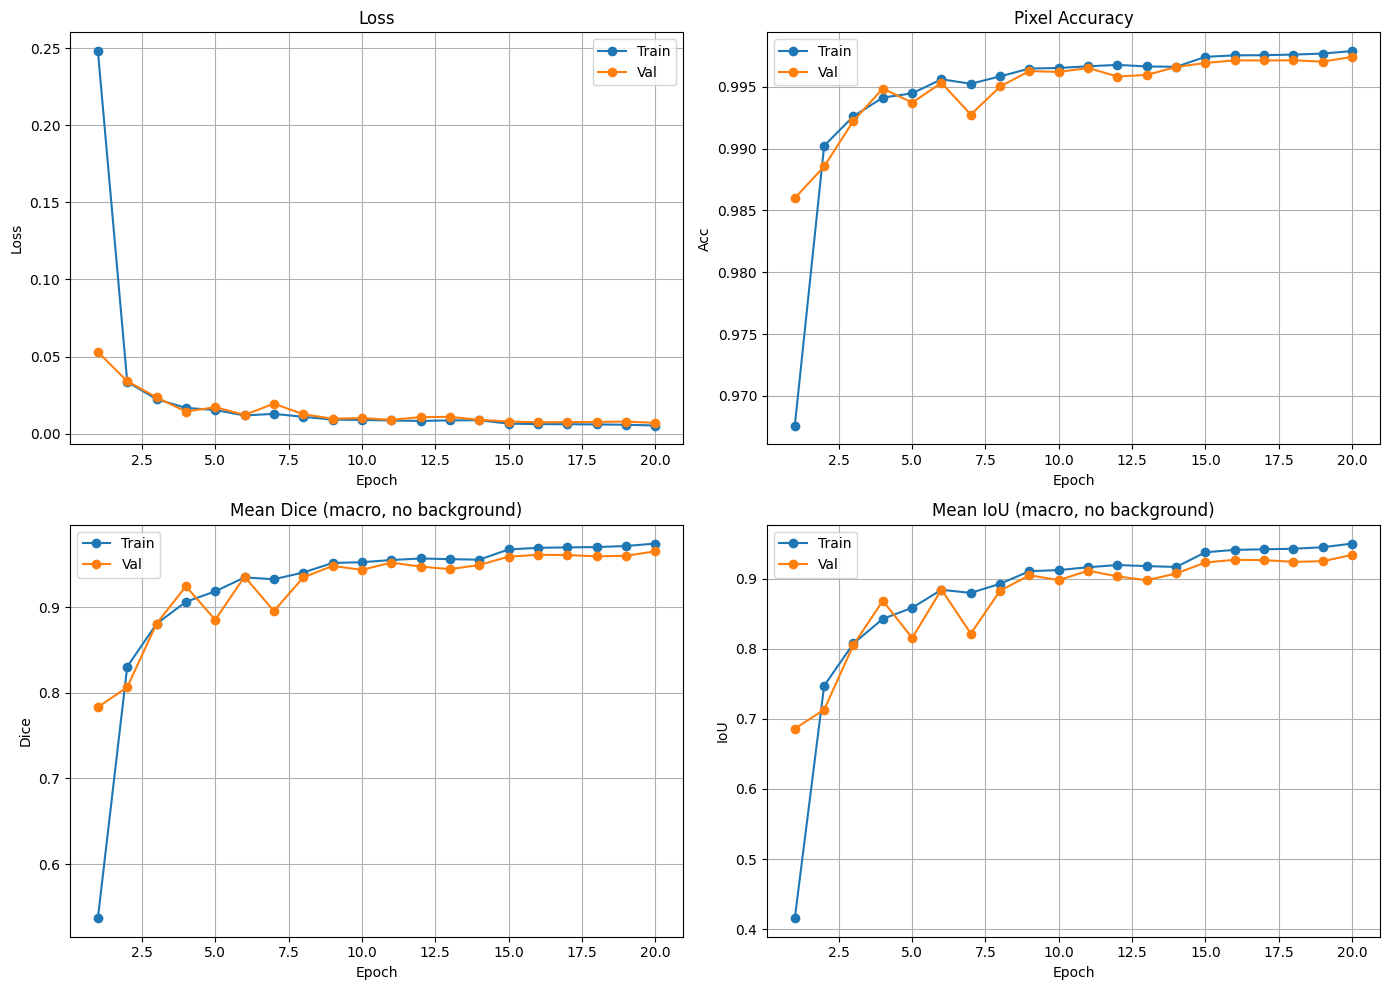

Saved: /kaggle/working/artifacts/metrics_basic.png


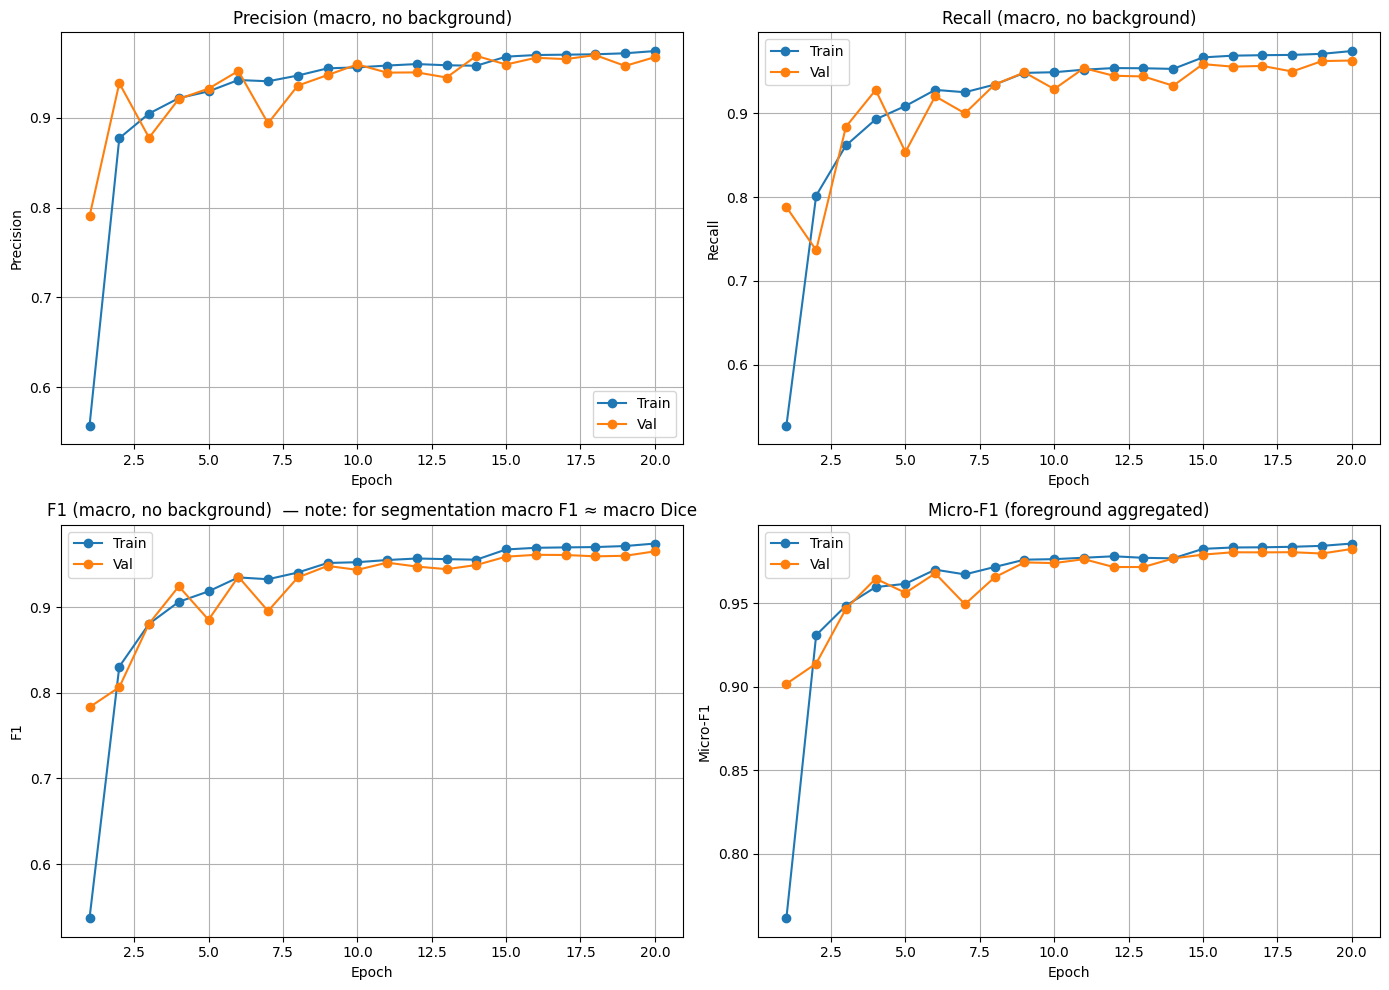

Saved: /kaggle/working/artifacts/metrics_prf.png


In [17]:
# ======================
# Cell 6: Plots (save + show)
# ======================
epochs_range = range(1, len(history["train_loss"]) + 1)

# ---- Basic 4 graphs ----
fig = plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epochs_range, history["train_loss"], label="Train", marker="o")
plt.plot(epochs_range, history["val_loss"],   label="Val",   marker="o")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs_range, history["train_acc"], label="Train", marker="o")
plt.plot(epochs_range, history["val_acc"],   label="Val",   marker="o")
plt.title("Pixel Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.grid(True); plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs_range, history["train_dice"], label="Train", marker="o")
plt.plot(epochs_range, history["val_dice"],   label="Val",   marker="o")
plt.title("Mean Dice (macro, no background)")
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.grid(True); plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs_range, history["train_iou"], label="Train", marker="o")
plt.plot(epochs_range, history["val_iou"],   label="Val",   marker="o")
plt.title("Mean IoU (macro, no background)")
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.grid(True); plt.legend()

plt.tight_layout()
basic_path = os.path.join(save_dir, "metrics_basic.png")
fig.savefig(basic_path, bbox_inches="tight")
plt.show()
plt.close(fig)

print("Saved:", basic_path)

# ---- Precision/Recall/F1 graphs ----
fig = plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epochs_range, history["train_precision"], label="Train", marker="o")
plt.plot(epochs_range, history["val_precision"],   label="Val",   marker="o")
plt.title("Precision (macro, no background)")
plt.xlabel("Epoch"); plt.ylabel("Precision"); plt.grid(True); plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs_range, history["train_recall"], label="Train", marker="o")
plt.plot(epochs_range, history["val_recall"],   label="Val",   marker="o")
plt.title("Recall (macro, no background)")
plt.xlabel("Epoch"); plt.ylabel("Recall"); plt.grid(True); plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs_range, history["train_f1"], label="Train", marker="o")
plt.plot(epochs_range, history["val_f1"],   label="Val",   marker="o")
plt.title("F1 (macro, no background)  — note: for segmentation macro F1 ≈ macro Dice")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.grid(True); plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs_range, history["train_micro_f1"], label="Train", marker="o")
plt.plot(epochs_range, history["val_micro_f1"],   label="Val",   marker="o")
plt.title("Micro-F1 (foreground aggregated)")
plt.xlabel("Epoch"); plt.ylabel("Micro-F1"); plt.grid(True); plt.legend()

plt.tight_layout()
prf_path = os.path.join(save_dir, "metrics_prf.png")
fig.savefig(prf_path, bbox_inches="tight")
plt.show()
plt.close(fig)

print("Saved:", prf_path)


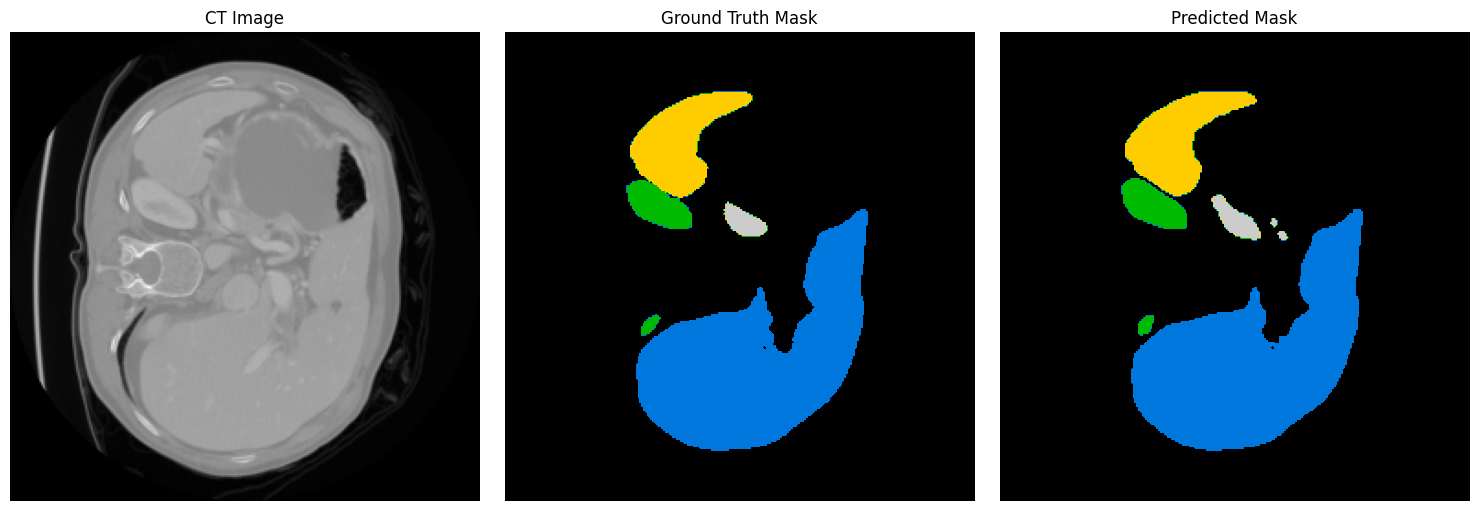

Saved sample prediction to: /kaggle/working/artifacts/sample_prediction.png
Unique labels in GT: [0 1 2 3 4]
Unique labels in Pred: [0 1 2 3 4]


In [18]:
# ======================
# Cell 7: Visualization sample (save PNG)
# ======================
# Load BEST weights for visualization
best_path = os.path.join(save_dir, "best_model_state_dict.pth")
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# discrete colormap for labels
cmap = plt.get_cmap("nipy_spectral", NUM_CLASSES)

imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)

with torch.no_grad():
    logits = model(imgs)
preds = torch.argmax(logits, dim=1).cpu().numpy()

imgs_np = imgs.cpu().numpy()
masks_np = masks.numpy()

idx = 0
img_slice = imgs_np[idx, 0]
gt_mask   = masks_np[idx]
pred_mask = preds[idx]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_slice, cmap="gray")
plt.title("CT Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()

out_pred = os.path.join(save_dir, "sample_prediction.png")
plt.savefig(out_pred, bbox_inches="tight")
plt.show()
plt.close()

print("Saved sample prediction to:", out_pred)
print("Unique labels in GT:", np.unique(gt_mask))
print("Unique labels in Pred:", np.unique(pred_mask))


In [19]:
# ======================
# Cell 8: Final checklist
# ======================
print("Artifacts folder:", save_dir)
print("Artifacts files:")
for f in sorted(os.listdir(save_dir)):
    print(" -", f)

print("\nNEXT STEP (IMPORTANT):")
print("1) Click 'Save Version' (Quick Save)")
print("2) Go to the notebook's 'Output' tab")
print("3) Click 'Create Dataset' from Output (keep it Private)")
print("   -> This lets you attach the saved model in any future notebook under /kaggle/input/...")


Artifacts folder: /kaggle/working/artifacts
Artifacts files:
 - best_checkpoint.pth
 - best_model_state_dict.pth
 - config.json
 - history.json
 - metrics_basic.png
 - metrics_prf.png
 - sample_prediction.png

NEXT STEP (IMPORTANT):
1) Click 'Save Version' (Quick Save)
2) Go to the notebook's 'Output' tab
3) Click 'Create Dataset' from Output (keep it Private)
   -> This lets you attach the saved model in any future notebook under /kaggle/input/...


Artifacts dir files: ['config.json', 'best_checkpoint.pth', 'metrics_basic.png', 'history.json', 'best_model_state_dict.pth', 'sample_prediction.png', 'metrics_prf.png']
Data dir files: ['sagittal', 'axial', 'coronal']
Loaded NUM_CLASSES = 5 | VAL_RATIO = 0.2 | SEED = 42
Device: cuda
Val samples: 1000
Loaded checkpoint. epoch: 20 best_val_f1: 0.9651161857163523
CM shape: torch.Size([5, 5]) | total pixels: 65536000


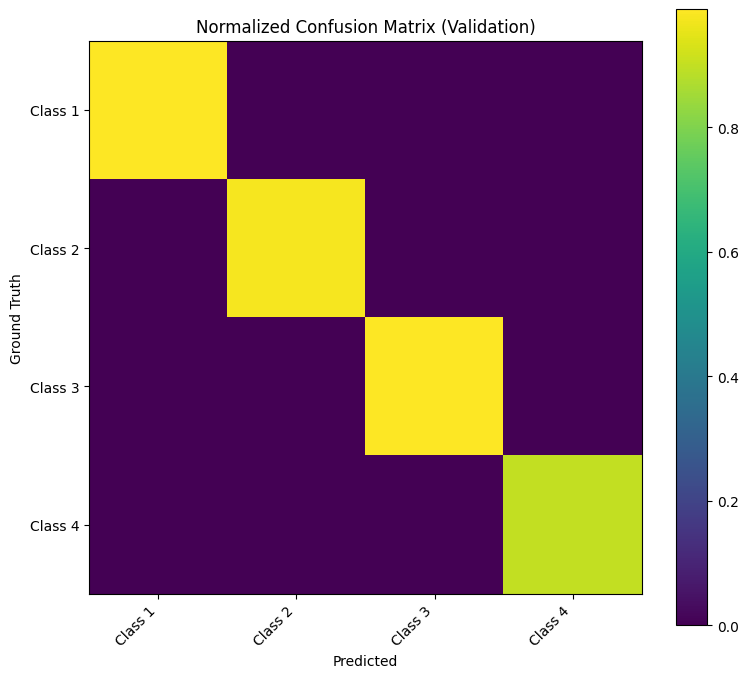

Saved confusion matrix to: /kaggle/working/artifacts/confusion_matrix_val.png


In [7]:
import os, json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# ---------- Paths ----------
ART_DIR = "/kaggle/input/flare21-unet-artifacts/flare21-unet-artifacts"      # your uploaded artifacts dataset
DATA_DIR = "/kaggle/input/converted-subset"          # your 2D dataset

print("Artifacts dir files:", os.listdir(ART_DIR))
print("Data dir files:", os.listdir(DATA_DIR))

# ---------- Load config ----------
with open(os.path.join(ART_DIR, "config.json"), "r") as f:
    cfg = json.load(f)

NUM_CLASSES = int(cfg["NUM_CLASSES"])
VAL_RATIO   = float(cfg.get("VAL_RATIO", 0.2))
SEED        = int(cfg.get("SEED", cfg.get("seed", 42)))

print("Loaded NUM_CLASSES =", NUM_CLASSES, "| VAL_RATIO =", VAL_RATIO, "| SEED =", SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Dataset / val_loader (same structure you used) ----------
AXIAL_IMG_DIR  = os.path.join(DATA_DIR, "axial", "images")
AXIAL_MASK_DIR = os.path.join(DATA_DIR, "axial", "masks")
assert os.path.isdir(AXIAL_IMG_DIR) and os.path.isdir(AXIAL_MASK_DIR), "Converted-subset axial folders not found!"

class AxialCTDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        assert len(self.img_files) > 0, "No images found!"

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        mask_name = img_name.replace("img_", "mask_")

        img = cv2.imread(os.path.join(self.img_dir, img_name), cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # [1,H,W]

        mask = cv2.imread(os.path.join(self.mask_dir, mask_name), cv2.IMREAD_UNCHANGED)
        mask = mask.astype(np.int64)       # [H,W]

        return torch.from_numpy(img), torch.from_numpy(mask)

dataset = AxialCTDataset(AXIAL_IMG_DIR, AXIAL_MASK_DIR)

n_total = len(dataset)
n_val = int(n_total * VAL_RATIO)
n_train = n_total - n_val

g = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=g)

val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
print("Val samples:", len(val_ds))

# ---------- UNet definition (must match training) ----------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super().__init__()
        self.inc   = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1   = Up(1024, 512 // factor, bilinear)
        self.up2   = Up(512, 256 // factor, bilinear)
        self.up3   = Up(256, 128 // factor, bilinear)
        self.up4   = Up(128, 64, bilinear)
        self.outc  = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)
        return self.outc(x)

model = UNet(n_channels=1, n_classes=NUM_CLASSES).to(device)

# ---------- Load best checkpoint ----------
ckpt = torch.load(os.path.join(ART_DIR, "best_checkpoint.pth"), map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print("Loaded checkpoint. epoch:", ckpt.get("epoch"), "best_val_f1:", ckpt.get("best_val_f1"))

# ---------- Confusion Matrix ----------
@torch.no_grad()
def get_confusion_matrix(model, loader, device, num_classes):
    cm_total = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

        p = preds.view(-1).cpu()
        t = masks.view(-1).cpu()

        valid = (t >= 0) & (t < num_classes)
        inds = num_classes * t[valid] + p[valid]
        cm = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
        cm_total += cm
    return cm_total

cm = get_confusion_matrix(model, val_loader, device, NUM_CLASSES)
print("CM shape:", cm.shape, "| total pixels:", cm.sum().item())

# ---------- Plot normalized CM ----------
cm_np = cm.numpy().astype(np.float64)
cm_norm = cm_np / (cm_np.sum(axis=1, keepdims=True) + 1e-9)

IGNORE_BG = True
class_names = [f"Class {i}" for i in range(NUM_CLASSES)]
if IGNORE_BG and NUM_CLASSES > 1:
    cm_plot = cm_norm[1:, 1:]
    names_plot = class_names[1:]
else:
    cm_plot = cm_norm
    names_plot = class_names

plt.figure(figsize=(8, 7))
plt.imshow(cm_plot)
plt.title("Normalized Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.xticks(range(len(names_plot)), names_plot, rotation=45, ha="right")
plt.yticks(range(len(names_plot)), names_plot)
plt.colorbar()
plt.tight_layout()

out_dir = "/kaggle/working/artifacts"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "confusion_matrix_val.png")
plt.savefig(out_path, bbox_inches="tight")
plt.show()

print("Saved confusion matrix to:", out_path)
